In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [48]:
def normalize(x, invert=True):
    x = (x - x.min()) / (x.max() - x.min())
    if invert:
        x = 1 - x
    return x

def to_img(x, invert=True):
    if invert:
        x = 1 - x
    return ((x - x.min()) / (x.max() - x.min()) * 255).astype(np.uint8)

def to_array(img):
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

def overlay(img, overlay_arr=None, figsize=(14, 18), ax=None, overlay_color=(255, 0, 0)): # red
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    img = np.stack([img, img, img], axis=2)
    if overlay_arr is not None:
        overlay_arr = cv2.dilate(overlay_arr, kernel=np.ones((3, 3), np.uint8))
        overlay_img = np.zeros_like(img, np.uint8)
        overlay_img[:,:] = np.array(overlay_color)
        img = (img * (1 - overlay_arr)[:,:,None] + overlay_img * overlay_arr[:,:,None]).astype(np.uint8)
    ax.imshow(img)

In [4]:
img = Image.open('roughness-study/rough_1.jpg')
img_clean = Image.open('roughness-study/clean_1.jpg')
w, h = img.size
img = img.resize((w//4, h//4))
img_clean = img_clean.resize((w//4, h//4))

In [5]:
img_arr = to_array(img)

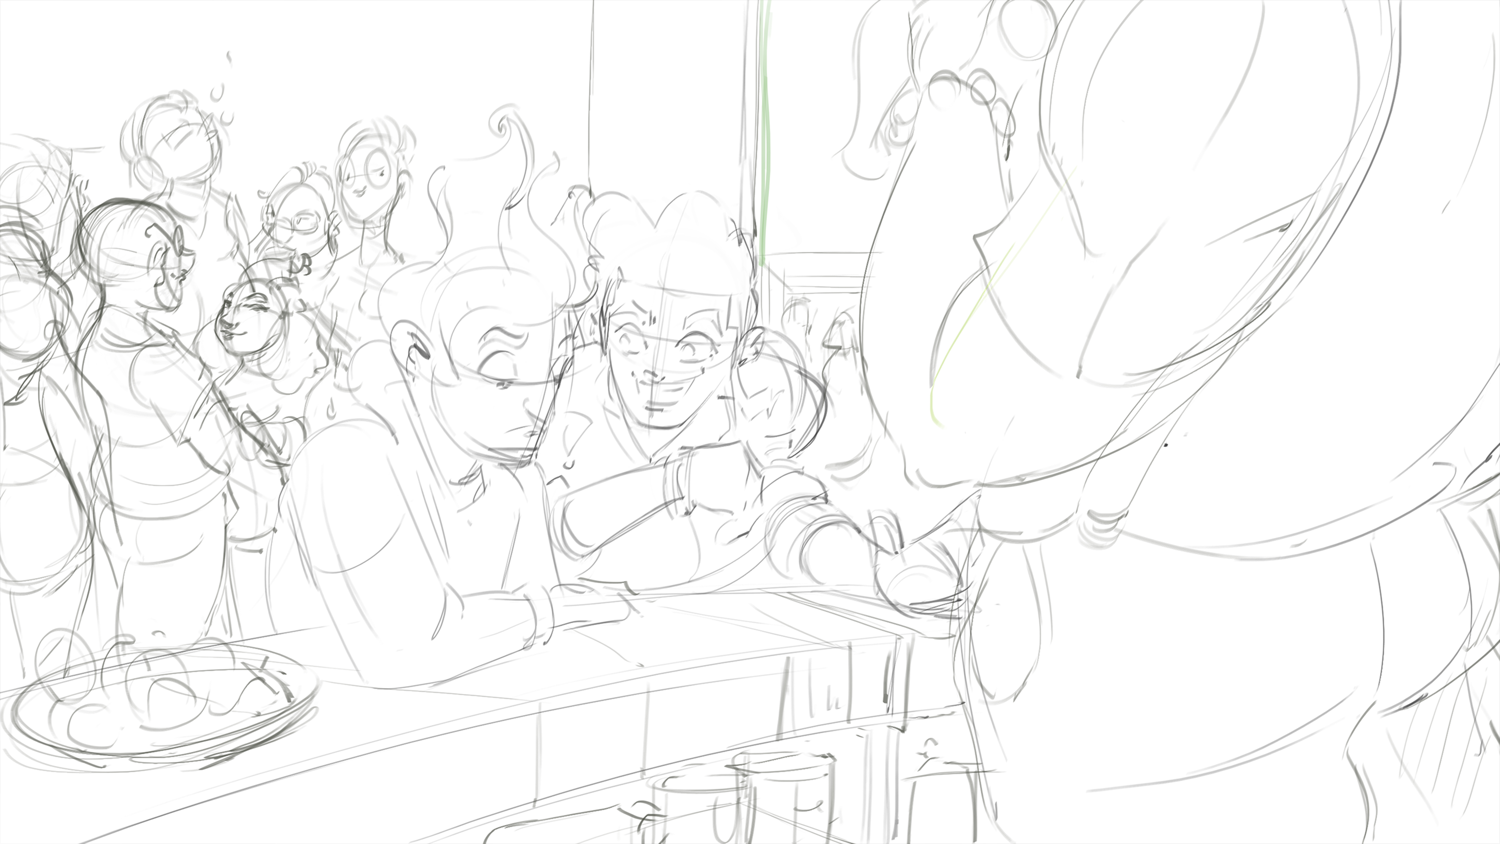

In [6]:
img

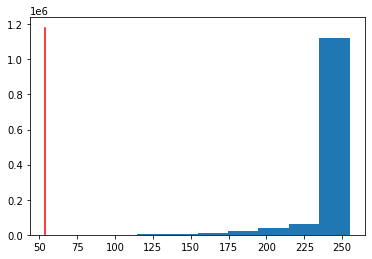

In [7]:
_ = plt.hist(img_arr.flatten())
plt.plot([img_arr.min()] * 2, plt.ylim(), color='r')

### Filter lines with via thresholding

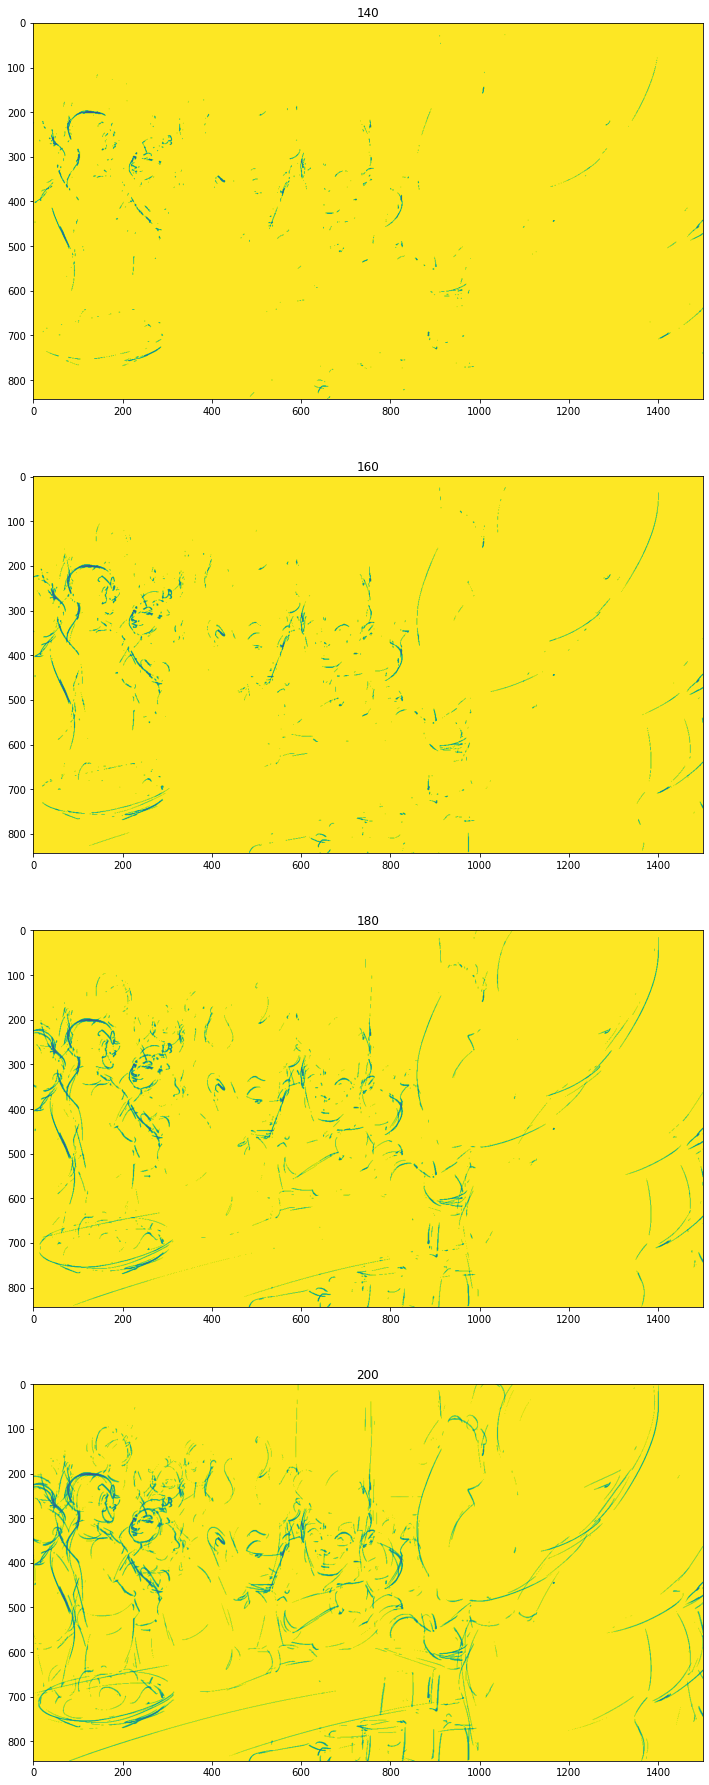

In [39]:
ts = [140, 160, 180, 200]
n = len(ts)
_, ax = plt.subplots(n, 1, figsize=(12, 32))
for i in range(n):
    img_arr_ = img_arr.copy()
    img_arr_[img_arr > ts[i]] = 255
    ax[i].imshow(img_arr_)
    ax[i].set_title(ts[i])

### Blur before processing

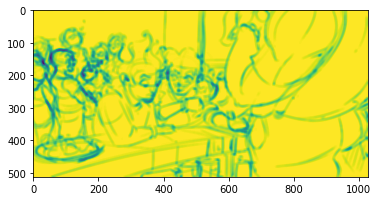

In [35]:
img_blur = cv2.GaussianBlur(cv2.resize(img_arr, (1028, 512)), (9, 9), 5)
plt.imshow(img_blur)

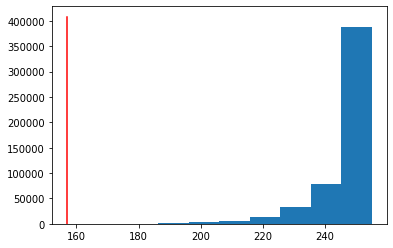

In [37]:
_ = plt.hist(img_blur.flatten())
plt.plot([img_blur.min()] * 2, plt.ylim(), color='r')

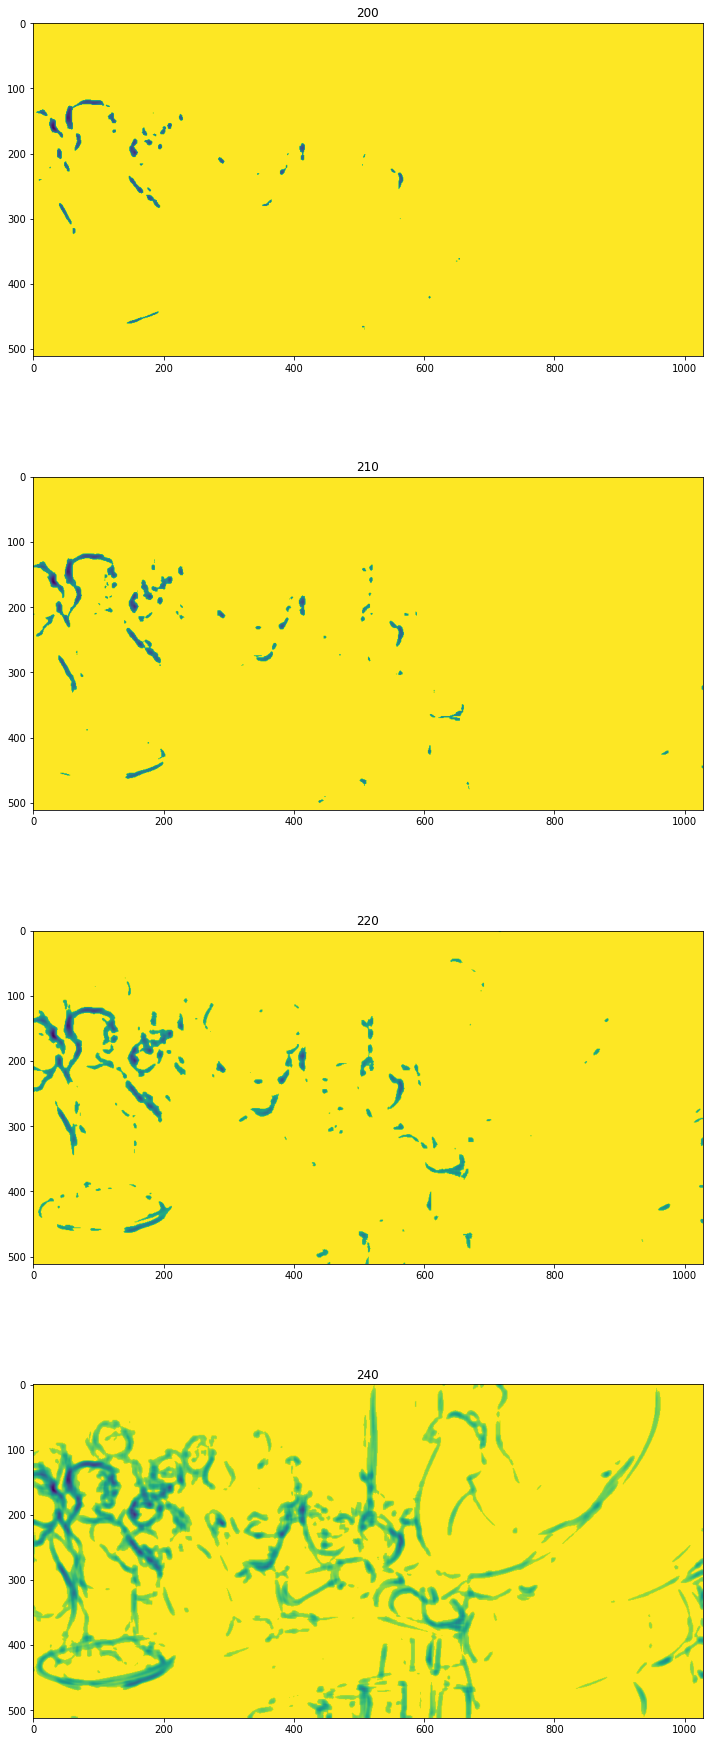

In [43]:
ts = [200, 210, 220, 240]
n = len(ts)
_, ax = plt.subplots(n, 1, figsize=(12, 32))
for i in range(n):
    img_arr_ = img_blur.copy()
    img_arr_[img_blur > ts[i]] = 255
    ax[i].imshow(img_arr_)
    ax[i].set_title(ts[i])

### Dynamically select threshold based on local intensities

In [44]:
filter_size = (17, 17)
img_resized = cv2.resize(img_arr, (1028, 512))

In [135]:
def min_pool(img, filter_size):
    w, h = filter_size
    img_ = np.ones_like(img) * 255
    for i in range(w):
        for j in range(h):
            filter_ = np.zeros(filter_size)
            filter_[i, j] = 1
            img_ = np.minimum(img_, cv2.filter2D(img, -1, filter_))
    return img_

def compute_norm(img, pooled):
    img_ = ((img - pooled) / 255 * (255 - pooled.min())).astype(np.uint8)
    img_[img == 255] = 255
    return img_

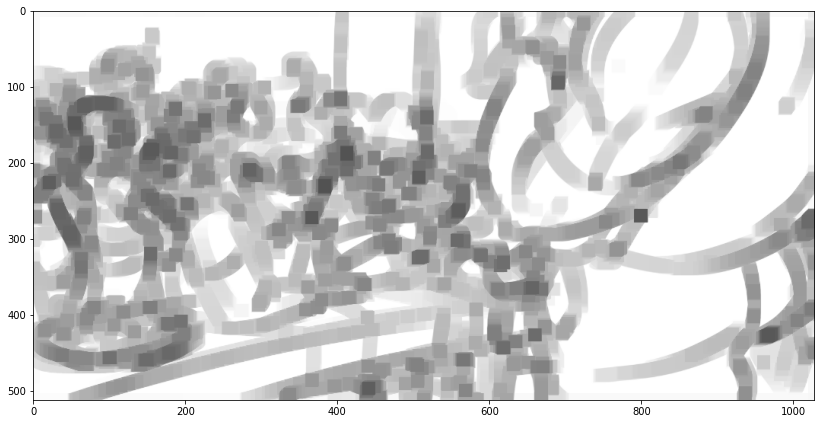

In [165]:
overlay(pooled)

In [87]:
pooled = min_pool(img_resized, (17, 17))

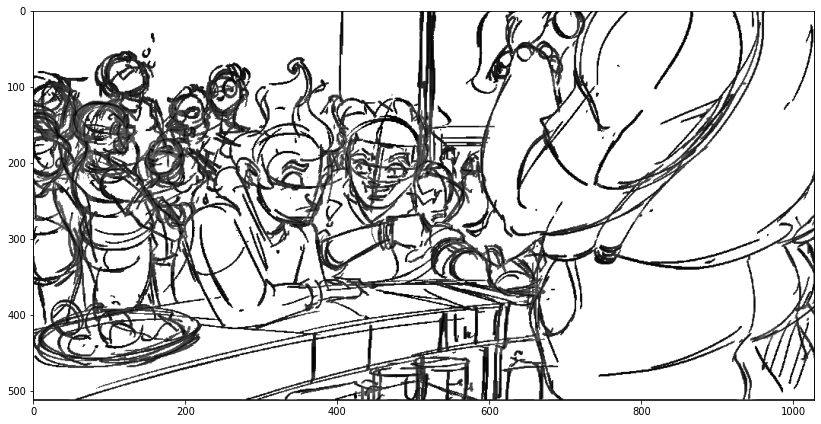

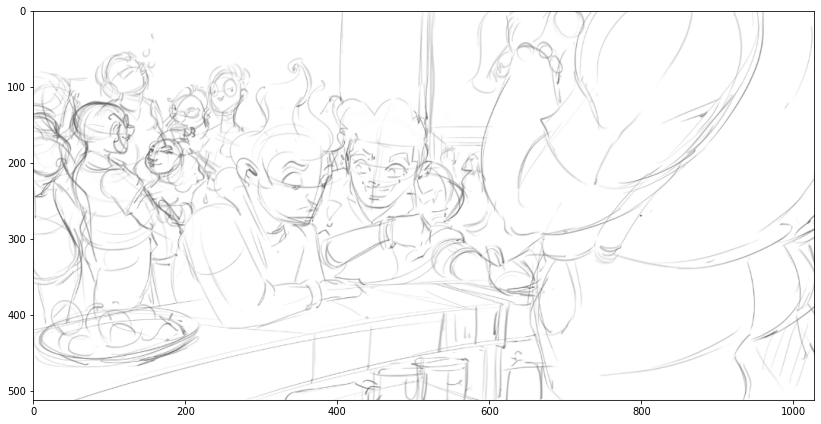

In [137]:
img_normed = compute_norm(img_resized, pooled)
overlay(img_normed)
overlay(img_resized)

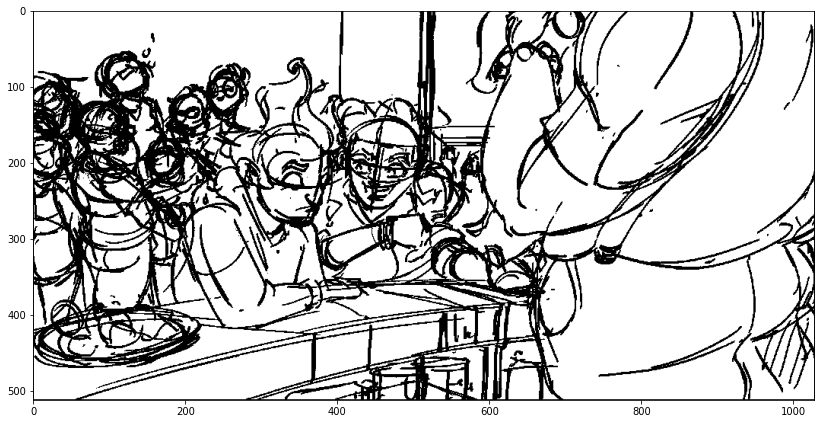

In [157]:
overlay((img_resized == 255).astype(np.uint8) * 255)

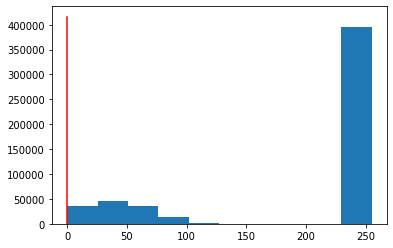

In [138]:
_ = plt.hist(img_normed.flatten())
plt.plot([img_normed.min()] * 2, plt.ylim(), color='r')

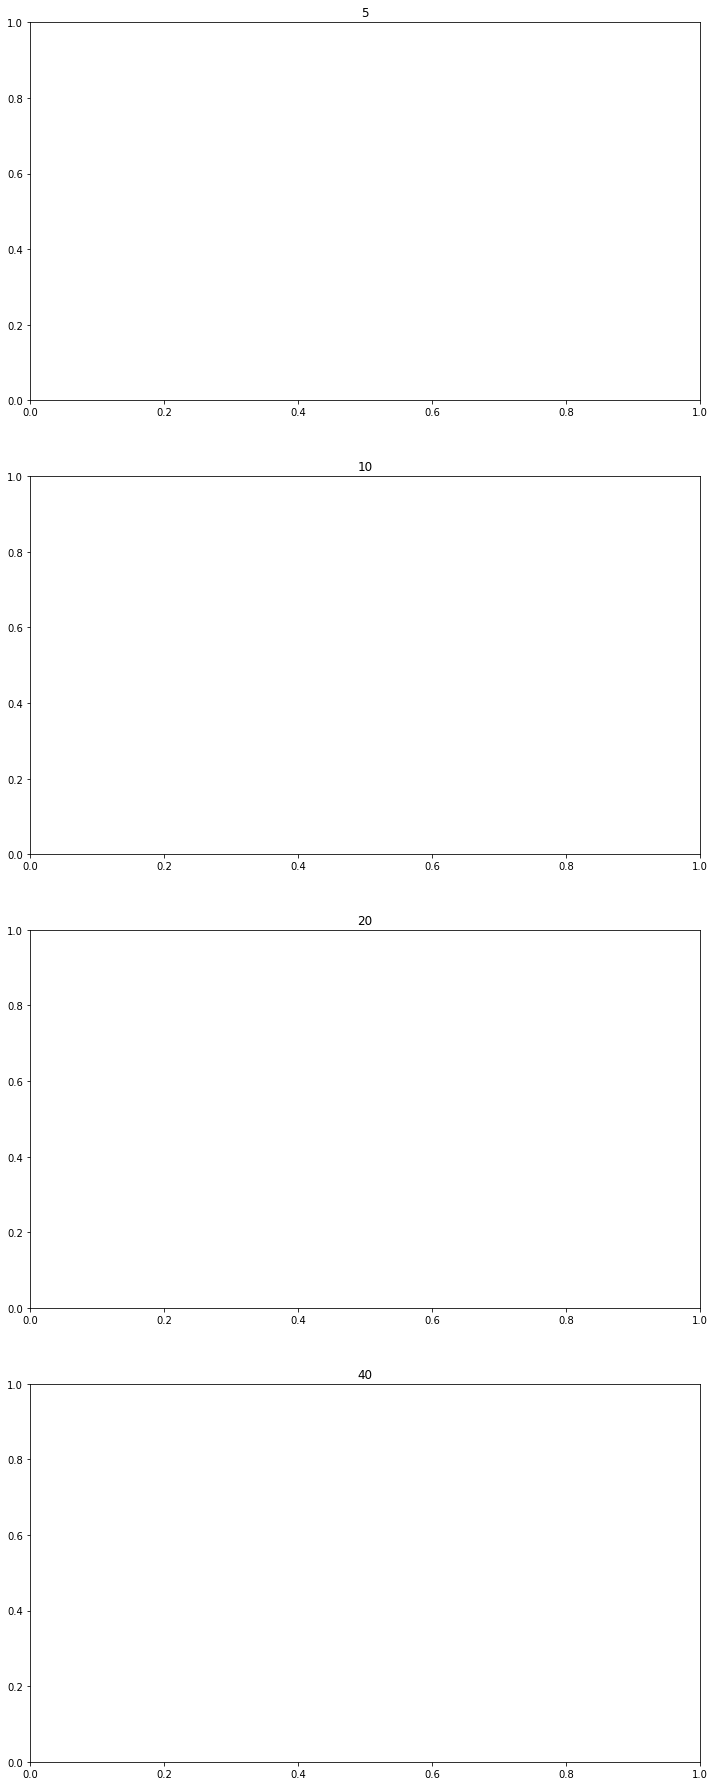

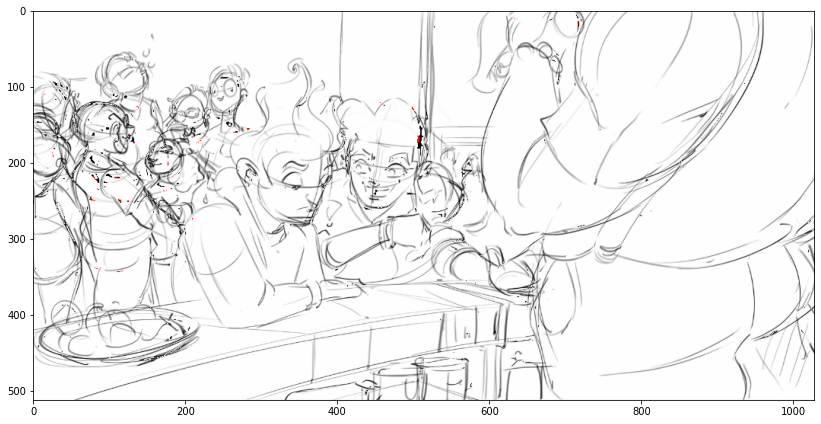

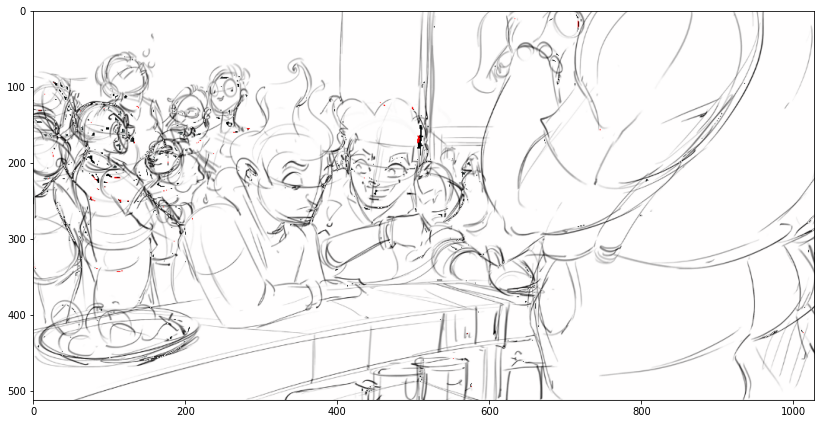

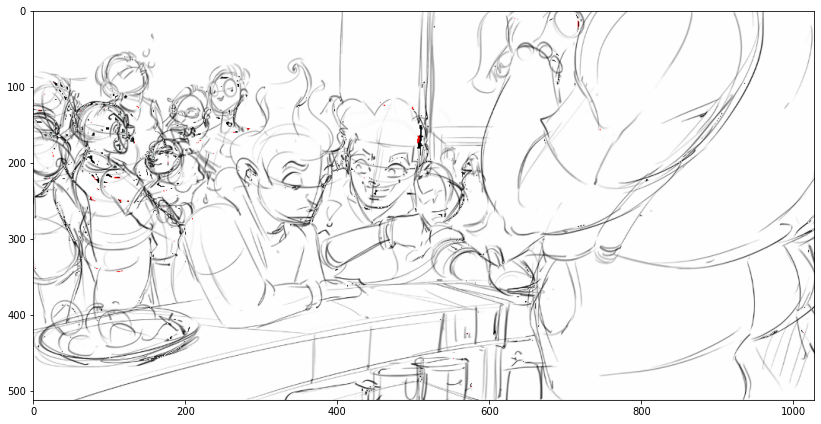

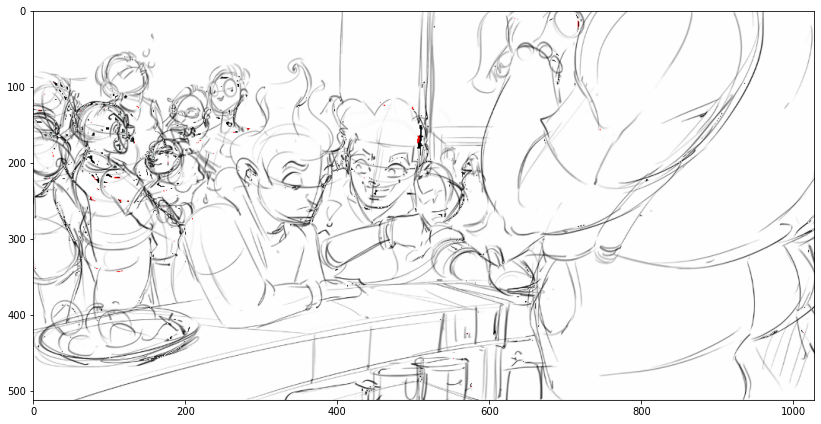

In [164]:
ts = [5, 10, 20, 40]
n = len(ts)
_, ax = plt.subplots(n, 1, figsize=(12, 32))
for i in range(n):
    img_arr_ = img_normed.copy()
    img_arr_[img_normed > ts[i]] = 255
    overlay(img_resized, img_arr_)
    ax[i].set_title(ts[i])

#### Try with gaussian blur rather than minpool 

In [150]:
def compute_norm_gauss(img, filter_size, sigma):
    pooled = cv2.GaussianBlur(img_resized, filter_size, sigma)
    img_ = ((img - pooled) / 255 * (255 - pooled.min())).astype(np.uint8)
    img_[img == 255] = 255
    return img_

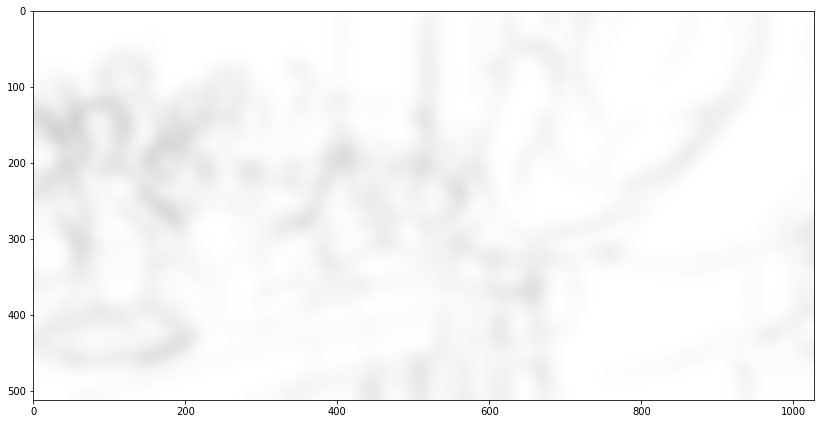

In [149]:
overlay(cv2.GaussianBlur(img_resized, (65, 65), 10))

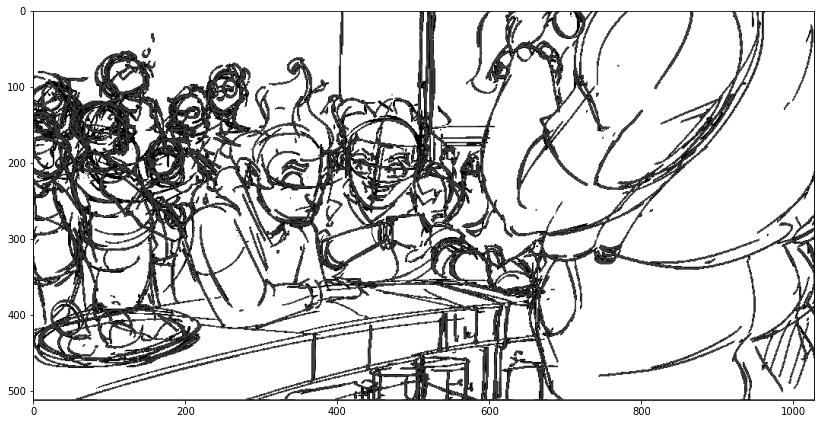

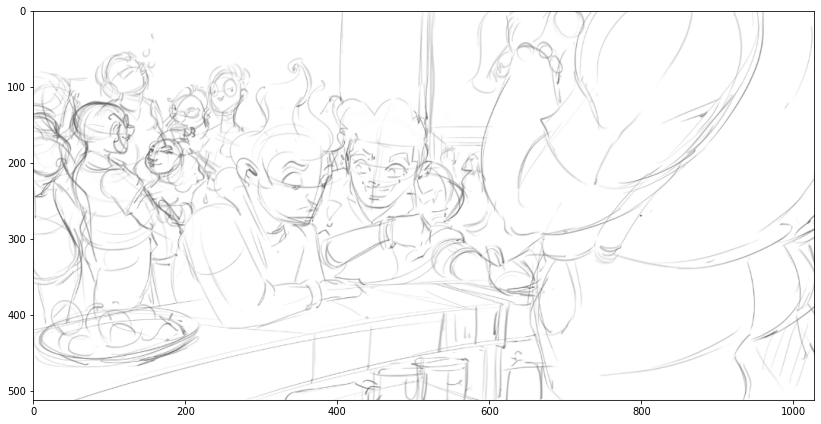

In [159]:
img_normed = compute_norm_gauss(img_resized, (65, 65), 5)
overlay(img_normed)
overlay(img_resized)

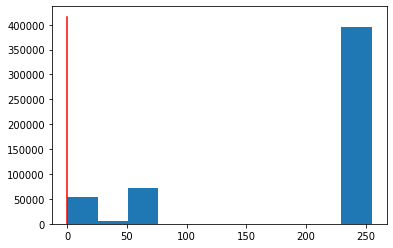

In [160]:
_ = plt.hist(img_normed.flatten())
plt.plot([img_normed.min()] * 2, plt.ylim(), color='r')

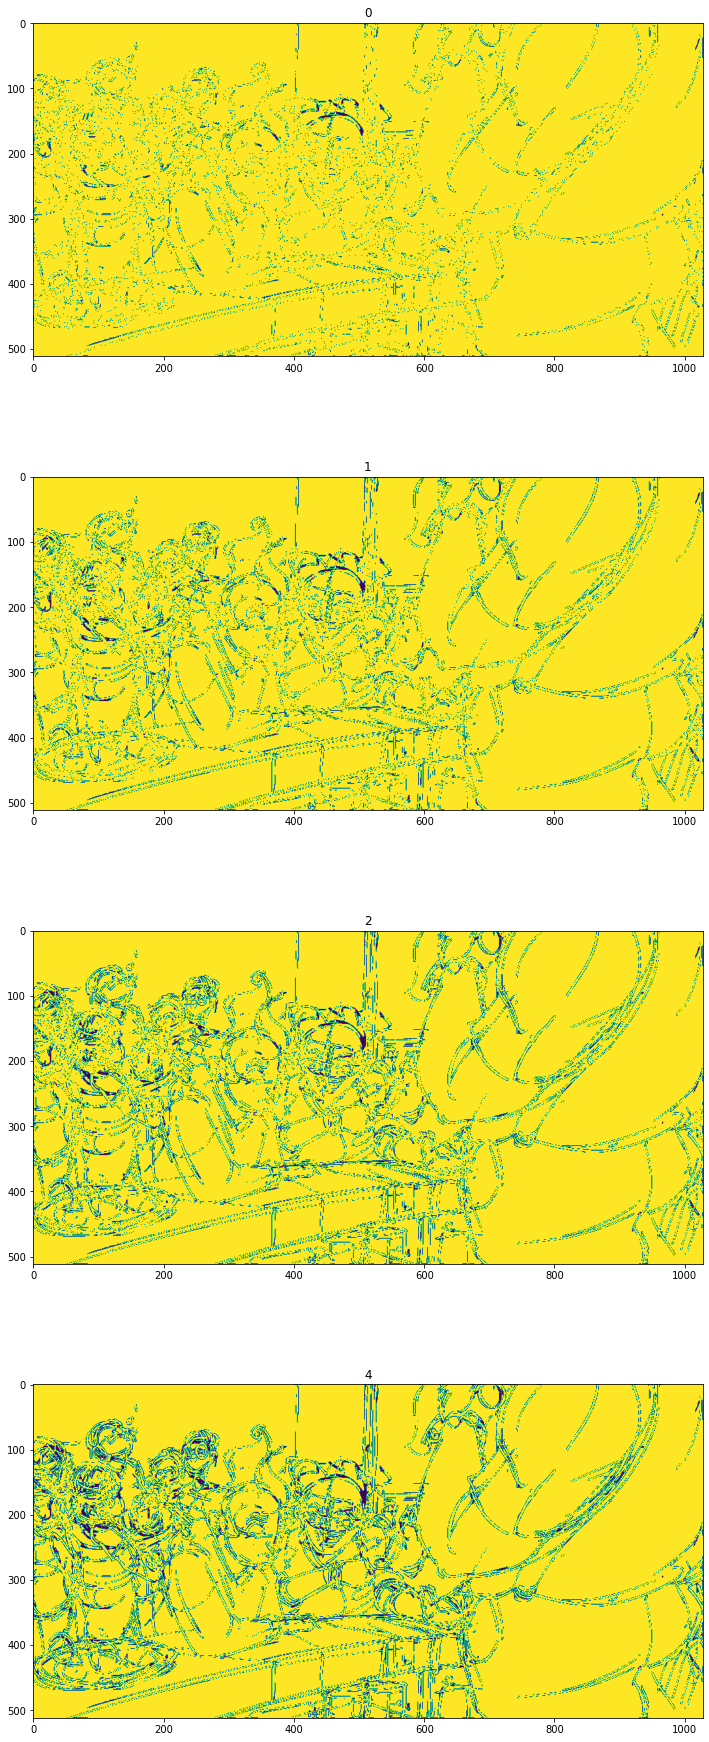

In [161]:
ts = [0, 1, 2, 4]
n = len(ts)
_, ax = plt.subplots(n, 1, figsize=(12, 32))
for i in range(n):
    img_arr_ = img_normed.copy()
    img_arr_[img_normed > ts[i]] = 255
    ax[i].imshow(img_arr_)
    ax[i].set_title(ts[i])

### Takeway
Filtering by intensity only helps when there are just enough high-intensity pixels to provide form without roughness